In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import lightgbm as lgb
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool
import subprocess
import matplotlib.pyplot as plt
import os
import time
from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold
from features import get_features
from features import encode_label
from features import encode_mean_k_fold
from features import encode_frequency
from features import encode_lda
from features import encode_pca

from report import report
from report import get_feature_importance
from report import submit_to_kaggle
import operator
from tqdm import tqdm
import seaborn as sns
import pprint as pp
from itertools import combinations

from tools import drop_cols
from tools import print_corr
from tools import compare_corr
from tools import dict_to_sortedlist

/Users/hyundai/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Load pickle

In [2]:
%%time
df_train = pd.read_pickle("input/train_lv01.pickle")
df_test = pd.read_pickle("input/test_lv01.pickle")

train_size = df_train.shape[0]
target_col = 'totals_transactionRevenue'
df_train[target_col].fillna(0.0, inplace=True)
df_train[target_col] = df_train[target_col].astype(float)


# Drop cols nunique < 2
del_cols = ['totals_bounces', 'totals_newVisits', 'visitId']
df_train = drop_cols(df_train, del_cols)
df_test = drop_cols(df_test, del_cols)

CPU times: user 7.84 s, sys: 2 s, total: 9.84 s
Wall time: 8.58 s


#### Corr df_train

["0 (('totals_hits', 'totals_pageviews'), 0.9832053703994799)",
 "1 (('date', 'visitStartTime'), 0.880936102208062)",
 "2 (('totals_pageviews', 'totals_transactionRevenue'), 0.1555900303995555)",
 "3 (('totals_hits', 'totals_transactionRevenue'), 0.1543325542147891)",
 "4 (('visitNumber', 'totals_transactionRevenue'), 0.05136636515154837)",
 "5 (('visitNumber', 'totals_pageviews'), 0.04336274534789543)",
 "6 (('visitNumber', 'totals_hits'), 0.04131692476474782)",
 "7 (('date', 'visitNumber'), 0.00753625750325383)",
 "8 (('date', 'totals_transactionRevenue'), 0.003187841368911753)",
 "9 (('visitStartTime', 'totals_transactionRevenue'), 0.0027237409240615683)",
 "10 (('visitNumber', 'visitStartTime'), 0.002068880592499275)",
 "11 (('date', 'totals_pageviews'), -0.012146094635337614)",
 "12 (('date', 'totals_hits'), -0.018394982375128884)",
 "13 (('visitStartTime', 'totals_pageviews'), -0.02225909838263856)",
 "14 (('visitStartTime', 'totals_hits'), -0.027700832340484788)"]


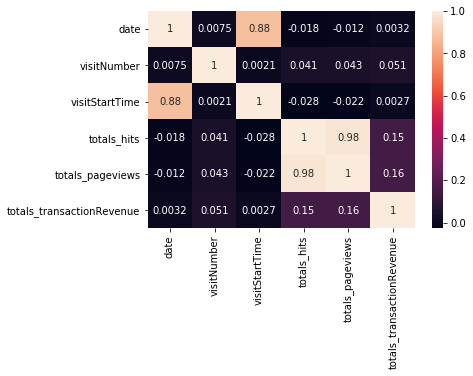

In [3]:
_ = print_corr(df_train.corr())

["0 (('totals_hits', 'totals_pageviews'), 0.9800575656037522)",
 "1 (('date', 'visitStartTime'), 0.8841553602961654)",
 "2 (('visitNumber', 'totals_transactionRevenue'), 0.3088951874376259)",
 "3 (('totals_hits', 'totals_transactionRevenue'), 0.14197348370080032)",
 "4 (('totals_pageviews', 'totals_transactionRevenue'), 0.12864390053779404)",
 "5 (('date', 'visitNumber'), 0.04088787281811942)",
 "6 (('visitNumber', 'visitStartTime'), 0.03130834911244912)",
 "7 (('visitNumber', 'totals_hits'), 0.027940255014209367)",
 "8 (('visitNumber', 'totals_pageviews'), 0.022058257363221638)",
 "9 (('date', 'totals_transactionRevenue'), 0.008099001691115252)",
 "10 (('visitStartTime', 'totals_transactionRevenue'), -0.003446551675520727)",
 "11 (('date', 'totals_pageviews'), -0.13483885435490942)",
 "12 (('date', 'totals_hits'), -0.13667552803199792)",
 "13 (('visitStartTime', 'totals_hits'), -0.16044639545289957)",
 "14 (('visitStartTime', 'totals_pageviews'), -0.1608370293017557)"]


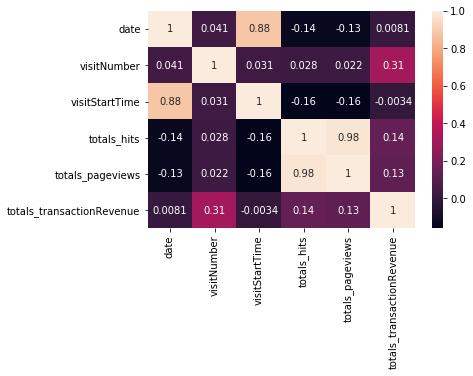

In [4]:
_ = print_corr(df_train[df_train[target_col] > 0].corr())

["0 (('date', 'visitStartTime'), 0.8808927238628838)",
 "1 (('date', 'totals_transactionRevenue'), nan)",
 "2 (('visitNumber', 'totals_transactionRevenue'), nan)",
 "3 (('visitStartTime', 'totals_pageviews'), -0.02376943767396431)",
 "4 (('visitStartTime', 'totals_transactionRevenue'), nan)",
 "5 (('totals_hits', 'totals_pageviews'), 0.980740094385847)",
 "6 (('visitNumber', 'totals_pageviews'), 0.039772247231075065)",
 "7 (('visitNumber', 'totals_hits'), 0.03718826336018407)",
 "8 (('date', 'visitNumber'), 0.006778133806378346)",
 "9 (('visitNumber', 'visitStartTime'), 0.001295115148952827)",
 "10 (('date', 'totals_pageviews'), -0.011927983947012395)",
 "11 (('date', 'totals_hits'), -0.018755569054836496)",
 "12 (('visitStartTime', 'totals_hits'), -0.029549762314588186)",
 "13 (('totals_hits', 'totals_transactionRevenue'), nan)",
 "14 (('totals_pageviews', 'totals_transactionRevenue'), nan)"]


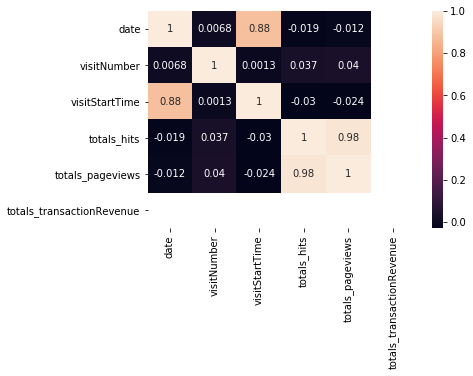

In [5]:
_ = print_corr(df_train[df_train[target_col] == 0].corr())

#### Corr df_test

["0 (('totals_hits', 'totals_pageviews'), 0.9746513723445873)",
 "1 (('date', 'visitStartTime'), 0.8762233183182011)",
 "2 (('visitNumber', 'totals_pageviews'), 0.03194171072593451)",
 "3 (('visitNumber', 'totals_hits'), 0.024853008542083593)",
 "4 (('date', 'visitNumber'), 0.018369869091977284)",
 "5 (('visitNumber', 'visitStartTime'), 0.017582765340019617)",
 "6 (('date', 'totals_hits'), 0.009609805461014713)",
 "7 (('date', 'totals_pageviews'), 0.009378603872817302)",
 "8 (('visitStartTime', 'totals_hits'), 0.008909053761453808)",
 "9 (('visitStartTime', 'totals_pageviews'), 0.008262644484900883)"]


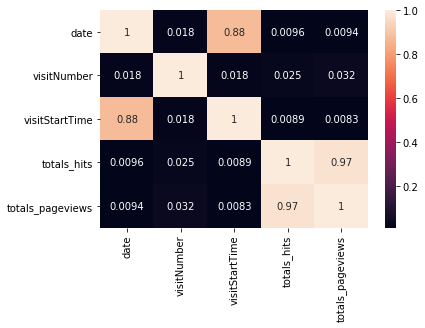

In [6]:
_ = print_corr(df_test.corr())

### DEV

#### trafficSource_medium

,trafficSource_medium,totals_hits
0,(none),4.928614
1,(not set),4.400000
2,affiliate,3.405475
3,cpc,6.499961
4,cpm,6.667199
5,organic,4.928795
6,referral,3.944231


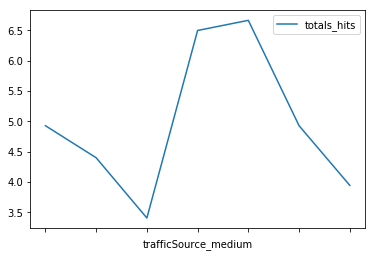

In [7]:
df_g = df_train.groupby(['trafficSource_medium'])['totals_hits'].mean().reset_index()
df_g.plot(x='trafficSource_medium')
df_g

,trafficSource_medium,totals_hits
0,(none),4.071541
1,(not set),1.764706
2,affiliate,3.477108
3,cpc,2.534803
4,cpm,5.960329
5,organic,4.505722
6,referral,4.423155


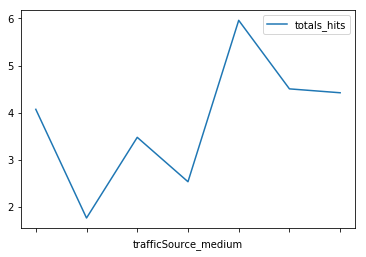

In [8]:
df_g = df_test.groupby(['trafficSource_medium'])['totals_hits'].mean().reset_index()
df_g.plot(x='trafficSource_medium')
df_g

#### *_hits_per_day

In [9]:
# df_g = df_train.groupby(['day'])['totals_hits'].sum().reset_index()
# df_g.plot()
# df_g

In [10]:
# df_g = df_test.groupby(['day'])['totals_hits'].sum().reset_index()
# df_g.plot()
# df_g

#### Freq

In [11]:
# corr_cols = [c for c in df_train_X if '_Fre' in c]
# corr_cols

#### Compare corr between train and test

In [12]:
# corr_cols = [c for c in df_train_X if '_Fre' in c]
corr_cols = df_test.columns
corr_dict, corr_train, corr_test = compare_corr(df_train[corr_cols], df_test[corr_cols])
pp.pprint(corr_dict)
pp.pprint(corr_train)
pp.pprint(corr_test)

{('date', 'totals_hits'): 0.028004787836143595,
 ('date', 'totals_pageviews'): 0.021524698508154916,
 ('date', 'visitNumber'): 0.010833611588723454,
 ('date', 'visitStartTime'): 0.00471278388986085,
 ('totals_hits', 'totals_pageviews'): 0.008553998054892542,
 ('visitNumber', 'totals_hits'): 0.016463916222664226,
 ('visitNumber', 'totals_pageviews'): 0.011421034621960917,
 ('visitNumber', 'visitStartTime'): 0.015513884747520343,
 ('visitStartTime', 'totals_hits'): 0.0366098861019386,
 ('visitStartTime', 'totals_pageviews'): 0.030521742867539444}
{('date', 'totals_hits'): -0.018394982375128884,
 ('date', 'totals_pageviews'): -0.012146094635337614,
 ('date', 'visitNumber'): 0.00753625750325383,
 ('date', 'visitStartTime'): 0.880936102208062,
 ('totals_hits', 'totals_pageviews'): 0.9832053703994799,
 ('visitNumber', 'totals_hits'): 0.04131692476474782,
 ('visitNumber', 'totals_pageviews'): 0.04336274534789543,
 ('visitNumber', 'visitStartTime'): 0.002068880592499275,
 ('visitStartTime', 't

In [13]:
dict_to_sortedlist(corr_dict)

["0 (('visitStartTime', 'totals_hits'), 0.0366098861019386)",
 "1 (('visitStartTime', 'totals_pageviews'), 0.030521742867539444)",
 "2 (('date', 'totals_hits'), 0.028004787836143595)",
 "3 (('date', 'totals_pageviews'), 0.021524698508154916)",
 "4 (('visitNumber', 'totals_hits'), 0.016463916222664226)",
 "5 (('visitNumber', 'visitStartTime'), 0.015513884747520343)",
 "6 (('visitNumber', 'totals_pageviews'), 0.011421034621960917)",
 "7 (('date', 'visitNumber'), 0.010833611588723454)",
 "8 (('totals_hits', 'totals_pageviews'), 0.008553998054892542)",
 "9 (('date', 'visitStartTime'), 0.00471278388986085)"]

### Feature Engineering

In [14]:
%%time
df_train, fea_cols = get_features(df_train)
df_test, fea_cols = get_features(df_test)
df_train[target_col] = np.log1p(df_train[target_col])

'fea_date_time'  17497.74 ms
'fea_format'  110.43 ms
'fea_device'  2219.12 ms
'fea_totals'  2387.89 ms
'fea_geo_network'  547.42 ms
'fea_traffic_source'  2734.66 ms
'fea_shift'  5922.25 ms
'fea_date_time'  15382.94 ms
'fea_format'  111.04 ms
'fea_device'  2269.88 ms
'fea_totals'  1820.57 ms
'fea_geo_network'  376.05 ms
'fea_traffic_source'  2675.22 ms
'fea_shift'  4920.27 ms
CPU times: user 1min 25s, sys: 11.1 s, total: 1min 36s
Wall time: 59 s


In [15]:
fea_cols

['user_hour_mean',
 'hour',
 'weekday',
 'month',
 'max_hits_per_day',
 'medium_hits_max',
 'max_hits_per_hour',
 'mean_pageviews_per_network_domain',
 'totals_hits_b1',
 'browser_operatingSystem',
 'totals_pageviews_b1',
 'medium_hits_min',
 'medium_hits_sum',
 'campaign_medium',
 'var_hits_per_day',
 'day',
 'mean_hits_per_hour',
 'sum_hits_per_day',
 'user_hour_min',
 'visitStartTime_b1_diff',
 'mean_hour_per_browser_operatingSystem',
 'sum_hits_per_network_domain',
 'visitStartTime_b2_diff',
 'month_unique_user_count',
 'hour_unique_user_count',
 'sum_hits_per_hour',
 'source_country',
 'weekday_unique_user_count',
 'browser_category',
 'medium_hits_mean',
 'user_hour_max']

#### corr df_train and df_test

["0 (('totals_hits_b1', 'totals_pageviews_b1'), 0.9973186406685033)",
 "1 (('totals_hits', 'totals_pageviews'), 0.9913443377932172)",
 "2 (('hour_unique_user_count', 'sum_hits_per_hour'), 0.956254363002254)",
 "3 (('hour', 'user_hour_mean'), 0.9156129898948033)",
 "4 (('user_hour_mean', 'user_hour_max'), 0.901766949347989)",
 "5 (('date', 'visitStartTime'), 0.880936102208062)",
 "6 (('user_hour_mean', 'user_hour_min'), 0.8688861698568336)",
 "7 (('hour', 'user_hour_max'), 0.8256695326804281)",
 "8 (('visitStartTime_b1_diff', 'totals_pageviews_b1'), 0.8133526668381402)",
 "9 (('visitStartTime_b1_diff', 'totals_hits_b1'), 0.8014309503018728)",
 "10 (('hour', 'user_hour_min'), 0.7955634638610078)",
 "11 (('visitNumber', 'visitStartTime_b2_diff'), 0.7541263673780185)",
 "12 (('hour', 'hour_unique_user_count'), 0.7215833116772377)",
 "13 (('hour', 'sum_hits_per_hour'), 0.7036260321877862)",
 "14 (('month', 'month_unique_user_count'), 0.7026930483006902)",
 "15 (('visitNumber', 'visitStartTi

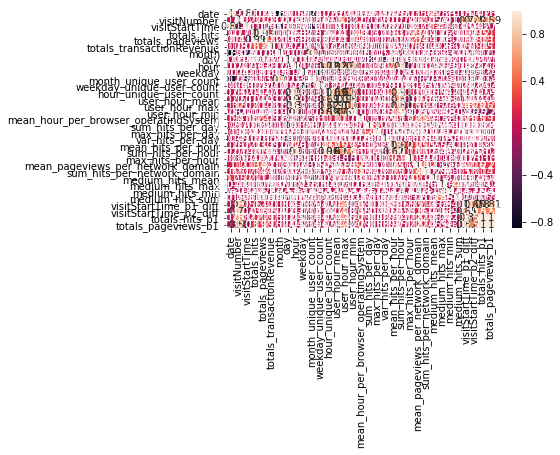

In [16]:
_ = print_corr(df_train.corr())

["0 (('totals_hits_b1', 'totals_pageviews_b1'), 0.9964299533095723)",
 "1 (('totals_hits', 'totals_pageviews'), 0.9878559228487707)",
 "2 (('hour_unique_user_count', 'sum_hits_per_hour'), 0.9765762367595666)",
 "3 (('hour', 'user_hour_mean'), 0.9075730270779645)",
 "4 (('user_hour_mean', 'user_hour_max'), 0.8914223179752869)",
 "5 (('date', 'visitStartTime'), 0.8762233183182011)",
 "6 (('user_hour_mean', 'user_hour_min'), 0.8649029707520625)",
 "7 (('visitStartTime_b1_diff', 'totals_pageviews_b1'), 0.81130794153178)",
 "8 (('hour', 'user_hour_max'), 0.809030851529575)",
 "9 (('visitStartTime_b1_diff', 'totals_hits_b1'), 0.7965137993059719)",
 "10 (('hour', 'user_hour_min'), 0.7849626072942254)",
 "11 (('medium_hits_mean', 'medium_hits_max'), 0.7747514310395078)",
 "12 (('visitNumber', 'visitStartTime_b2_diff'), 0.7578660509708949)",
 "13 (('medium_hits_mean', 'medium_hits_sum'), 0.7354684113713564)",
 "14 (('visitNumber', 'visitStartTime_b1_diff'), 0.7027667030224408)",
 "15 (('mean_hi

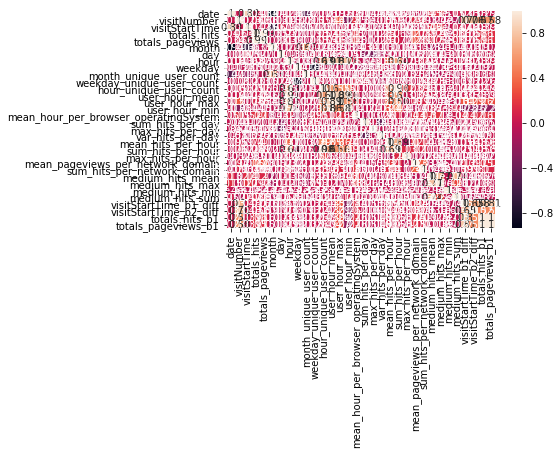

In [17]:
_ = print_corr(df_test.corr())

#### ttest between df_train and df_test

In [18]:
# from scipy.stats import ttest_ind
# c = 'browser_category'
# print(c, ttest_ind(df_train[c], df_test[c], equal_var=False))

# for c in fea_cols:
#     print(c, ttest_ind(df_train[c], df_test[c], equal_var=False))

### Encodings

In [19]:
not_used_cols = [
    "date",
    "fullVisitorId",
    "sessionId",
    "visitId",
    'trafficSource_campaignCode',
    target_col,
    #     "visitNumber",
    #     "visitStartTime",
    #     'trafficSource_referralPath',
]

categorical_feature = df_train.select_dtypes(include='object').columns
categorical_feature = [
    c for c in categorical_feature if c not in not_used_cols
]
df_train[categorical_feature].fillna('NA_NULL', inplace=True)
df_test[categorical_feature].fillna('NA_NULL', inplace=True)

len(categorical_feature)

/Users/hyundai/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


28

#### Label Encoding

In [20]:
df_train, df_test = encode_label(df_train, df_test, categorical_feature)

['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'browser_category', 'browser_operatingSystem', 'source_country', 'campaign_medium']


100%|██████████| 28/28 [00:45<00:00,  1.24s/it]


'encode_label'  51375.24 ms


#### Freq Encoding

In [21]:
df_train, df_test = encode_frequency(df_train, df_test, categorical_feature)

100%|██████████| 28/28 [00:31<00:00,  1.19s/it]

(903653, 91) (804684, 90)
'encode_frequency'  32949.95 ms


#### Mean Encoding

In [22]:
df_train, df_test = encode_mean_k_fold(df_train, df_test, categorical_feature, target_col)

100%|██████████| 28/28 [01:41<00:00,  3.76s/it]

(903653, 119) (804684, 118)
Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem',
       ...
       'mean_k_fold_trafficSource_campaign',
       'mean_k_fold_trafficSource_isTrueDirect',
       'mean_k_fold_trafficSource_keyword', 'mean_k_fold_trafficSource_medium',
       'mean_k_fold_trafficSource_referralPath',
       'mean_k_fold_trafficSource_source', 'mean_k_fold_browser_category',
       'mean_k_fold_browser_operatingSystem', 'mean_k_fold_source_country',
       'mean_k_fold_campaign_medium'],
      dtype='object', length=119)
'encode_mean_k_fold'  101600.46 ms


#### LDA (target_col) : 망함

In [23]:
# y_categorized = np.digitize(df_train[target_col], bins=np.arange(2,24,2))
# clf = LinearDiscriminantAnalysis(n_components=10)
# clf.fit(df_train[categorical_feature], y_categorized)

In [24]:
# df_train_lda = pd.DataFrame(clf.transform(df_train[categorical_feature]))
# df_test_lda = pd.DataFrame(clf.transform(df_test[categorical_feature]))

# col_map={i:'lda_{}'.format(i) for i in range(10)}
# df_train_lda.rename(columns=col_map, inplace=True)
# df_test.rename(columns=col_map, inplace=True)

# df_train = pd.concat([df_train, df_train_lda], axis=1)
# df_test = pd.concat([df_test, df_test_lda], axis=1)                

#### LDA (totals_hits) : good

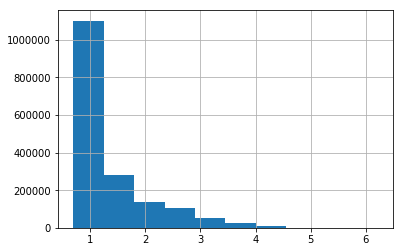

In [25]:
y_col = 'totals_hits'
merged_y = pd.concat([df_train[y_col], df_test[y_col]])
merged_y.hist()
y_categorized = np.digitize(merged_y, bins=np.arange(0,6,1))

In [26]:
df_train, df_test = encode_lda(df_train, df_test, categorical_feature, y_categorized, fea_name=y_col)

lda_totals_hits_0to9
(903653, 124) (804684, 123)
'encode_lda'  8017.85 ms


#### LDA (totals_pageviews) : better

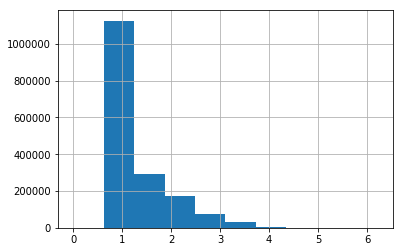

In [27]:
y_col = 'totals_pageviews'
merged_y = pd.concat([df_train[y_col], df_test[y_col]])
merged_y.hist()
y_categorized = np.digitize(merged_y, bins=np.arange(0,6,1))

In [28]:
df_train, df_test = encode_lda(df_train, df_test, categorical_feature, y_categorized, fea_name=y_col)

lda_totals_pageviews_0to9


/Users/hyundai/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


(903653, 129) (804684, 128)
'encode_lda'  8353.48 ms


#### LDA (hits / pageviews) : 망함

In [29]:
# y_col = 'hits_pageviews_rate'
# merged_y = pd.concat([
#     df_train['totals_hits'] / df_train['totals_pageviews'],
#     df_test['totals_hits'] / df_test['totals_pageviews']
# ])
# merged_y[np.isinf(merged_y)] = 0
# merged_y = merged_y * 10
# merged_y.hist()

In [30]:
# bins = np.arange(10,25,1)
# bins = np.insert(bins, 0, 0)
# y_categorized = np.digitize(merged_y, bins=bins)
# np.unique(y_categorized, return_counts=True)

In [31]:
# df_train, df_test = encode_lda(df_train, df_test, categorical_feature, y_categorized, fea_name=y_col)

#### PCA (totals_hits) : 

In [32]:
# y_col = 'totals_hits'
# merged_y = pd.concat([df_train[y_col], df_test[y_col]])
# merged_y.hist()
# y_categorized = np.digitize(merged_y, bins=np.arange(0,6,1))

In [33]:
# df_train, df_test = encode_pca(df_train, df_test, categorical_feature, y_categorized, fea_name=y_col)

### Split X and y, Remove not_used_cols

In [34]:
df_train_y = df_train[target_col].astype(float)

df_train_idx = df_train[['fullVisitorId', target_col]]
df_train_X = drop_cols(df_train.copy(), not_used_cols)

df_test_idx = df_test[['fullVisitorId']]
df_test_X = drop_cols(df_test.copy(), not_used_cols)

In [35]:
del_cols = [c for c in df_train_X.columns if 'lda_totals_hits' in c]
df_train_X.drop(del_cols, axis=1, inplace=True)
df_test_X.drop(del_cols, axis=1, inplace=True)

### Training 531

In [36]:
feature_name = list(df_train_X.columns)
print(feature_name)
prediction_train = np.zeros(df_train_X.shape[0])
prediction = np.zeros(df_test_X.shape[0])

['channelGrouping', 'visitNumber', 'visitStartTime', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_hits', 'totals_pageviews', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'month', 'day', 'hour', 'weekday', 'month_unique_user_count', 'weekday_unique_user_count', 'hour_unique_user_count', 'user_hour_mean', 'user_hour_max', 'user_hour_min', 'browser_category', 'browser_operatingSystem', 'mean_hour_per_browser_operatingSystem', 'source_co

In [40]:
submit_file_path = ''


def modeling(X_train, X_valid, y_train, y_valid, params, model_tag):
    print('X_train:', X_train.shape, 'X_valid:', X_valid.shape, 'Rate:',
          X_valid.shape[0] / X_train.shape[0])
    if X_valid.shape[0] / X_train.shape[0] > 1.0:
        print('No Execution')
        return

    train = lgb.Dataset(
        X_train.values,
        label=y_train.values,
        feature_name=feature_name,
        #                 categorical_feature=categorical_feature
    )

    valid = lgb.Dataset(
        X_valid.values,
        label=y_valid.values,
        feature_name=feature_name,
        #                 categorical_feature=categorical_feature
    )

    evals_result = {}
    train_params = {
        'params': params,
        'train_set': train,
        'valid_sets': [train, valid],
        'valid_names': ['train', 'valid'],
        'early_stopping_rounds': 300,  #50
        'num_boost_round': 10000,  #500
        'verbose_eval': 25,
        'feval': None,
        'evals_result': evals_result,
        #     'categorical_feature': 'auto',
    }

    model = lgb.train(**train_params)

    global prediction_train, prediction
    print('predict train set')
    pred_train = model.predict(
        df_train_X.values, num_iteration=model.best_iteration)
    prediction_train += pred_train
    df_fold_train = df_train_idx.copy()
    df_fold_train[model_tag] = pred_train

    print('predict test set')
    pred = model.predict(df_test_X.values, num_iteration=model.best_iteration)
    prediction += pred
    df_fold_test = df_test_idx.copy()
    df_fold_test[model_tag] = pred

    # report
    global submit_file_path
    submit_file_path = ''
    msg = [model_tag, str(df_train_X.columns), str(train_params)]
    submit_file_path = report(df_fold_train, df_fold_test, pred_train, pred,
                              msg, model)
    print(submit_file_path)

    return model

In [41]:
#     params = {
#         "objective": "regression",
#         "metric": "rmse",
#         "max_depth": 8,
#         "min_child_samples": 20,
#         "reg_alpha": 1,
#         "reg_lambda": 1,
#         "num_leaves": 257,
#         "learning_rate": 0.01,
#         "subsample": 0.8,
#         "colsample_bytree": 0.8,
#         "subsample_freq ": 5,
#     }
#     params = {
#     "objective": "regression",
#     "metric": "rmse",
#     "num_leaves": 30,
#     "min_child_samples": 100,
#     "learning_rate": 0.1,
#     "bagging_fraction": 0.7,
#     "feature_fraction": 0.5,
#     "bagging_frequency": 5,
#     "bagging_seed": 2018,
#     "verbosity": -1
# }

# param = {
#     "objective": "regression",
#     "metric": "rmse",
#     "max_depth": 8,
#     "min_child_samples": 21,
#     "reg_alpha": 1,
#     "reg_lambda": 1,
#     "num_leaves": 257,
#     "learning_rate": 0.01,
#     "subsample": 0.82,
#     "colsample_bytree": 0.84,
#     "verbosity": -1
# }

params = {
    "boosting_type": 'gbdt',  #'dart', #gbdt',
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 30,
    "min_child_samples": 100,
    "learning_rate": 0.1,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.5,
    "bagging_frequency": 5,
    "bagging_seed": 1989,
    "verbosity": -1,
    'seed': 1989
}
cond = df_train['date'] <= 20170531
X_train, X_valid = df_train_X[cond], df_train_X[~cond]
y_train, y_valid = df_train_y[cond], df_train_y[~cond]

model = modeling(X_train, X_valid, y_train, y_valid, params, 'once')

X_train: (765707, 120) X_valid: (137946, 120) Rate: 0.18015507237102443
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.62544	valid's rmse: 1.73494
[50]	train's rmse: 1.57542	valid's rmse: 1.69763
[75]	train's rmse: 1.55154	valid's rmse: 1.68872
[100]	train's rmse: 1.53387	valid's rmse: 1.6861
[125]	train's rmse: 1.51715	valid's rmse: 1.68377
[150]	train's rmse: 1.50403	valid's rmse: 1.68382
[175]	train's rmse: 1.4887	valid's rmse: 1.682
[200]	train's rmse: 1.47474	valid's rmse: 1.68097
[225]	train's rmse: 1.4655	valid's rmse: 1.68095
[250]	train's rmse: 1.45275	valid's rmse: 1.68079
[275]	train's rmse: 1.44294	valid's rmse: 1.68093
[300]	train's rmse: 1.4348	valid's rmse: 1.68147
[325]	train's rmse: 1.4255	valid's rmse: 1.68103
[350]	train's rmse: 1.41681	valid's rmse: 1.68144
[375]	train's rmse: 1.40869	valid's rmse: 1.68218
[400]	train's rmse: 1.40159	valid's rmse: 1.68283
[425]	train's rmse: 1.39569	valid's rmse: 1.68281
[450]	train's rmse: 1.388

raw_train: results/2018-09-29T234240__T1.447_V1.680_R1.161_K/reg_train_2018-09-29T234240.csv
raw_test: results/2018-09-29T234240__T1.447_V1.680_R1.161_K/reg_test_2018-09-29T234240.csv
submit: results/2018-09-29T234240__T1.447_V1.680_R1.161_K/aiden_2018-09-29T234240.csv.tar.gz
cp -f *py* results/2018-09-29T234240__T1.447_V1.680_R1.161_K
    
results/2018-09-29T234240__T1.447_V1.680_R1.161_K/aiden_2018-09-29T234240.csv.tar.gz


### Submit

In [ ]:
# kaggler = ['aidensong', 'zooicl', 'zooicl84']
# user = kaggler[0]
# print(kaggler, submit_file_path)
# msg = """freq / mean / lda hits / lda hit-page rate encode, add fea, remove high corr fea, 531"""
# submit_to_kaggle(user, submit_file_path, msg)

### ETC

In [ ]:
corr_cols = [c for c in df_train_X if 'mean_k_fold_' in c]
corr_cols

In [ ]:
df_train_X['mean_k_fold_channelGrouping'].value_counts()

In [ ]:
df_test['mean_k_fold_channelGrouping'].value_counts()